# 1 準備

In [1]:
!nvidia-smi

Wed Jun 15 10:14:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# データ作成に使用するライブラリ
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# モデル作成に使用するライブラリ
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# よく使用するライブラリ
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1)

In [3]:
batch_size = 100
n_channel = 100
n_epoch = 100

In [4]:
# データの読み込み
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), lambda x: x.view(-1)])

root = './data'
mnist_dataset = datasets.MNIST(root=root,download=True,train=True,transform=transform)
dataloader = DataLoader(mnist_dataset,batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# gpuの指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 2 モデル

In [6]:
class Generator(nn.Module):

    def __init__(self):

        super(Generator, self).__init__()

        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.Linear(n_channel, 128),
                nn.BatchNorm1d(128),
                nn.ReLU()
            ),
            'layer1': nn.Sequential(
                nn.Linear(128, 256),
                nn.BatchNorm1d(256),
                nn.ReLU()
            ),  
            'layer2': nn.Sequential(
                 nn.Linear(256, 784),
                nn.Tanh()
            )   
        })

    def forward(self, z):

        for layer in self.layers.values():
            z = layer(z)
        return z


In [7]:
class Discriminator(nn.Module):

    def __init__(self):

        super(Discriminator, self).__init__()

        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.Linear(784, 256),
                nn.LeakyReLU(negative_slope=0.2) 
            ),  
            'layer1': nn.Sequential(
                nn.Linear(256, 128),
                nn.LeakyReLU(negative_slope=0.2)
            ),   
            'layer2': nn.Sequential(
                nn.Linear(128, 1),
                nn.Sigmoid() 
            )    
        })

    def forward(self, x):
        for layer in self.layers.values():  
            x = layer(x)
        return x.squeeze()

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [9]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(generator.parameters())
optimizerD = optim.Adam(discriminator.parameters())

# 3 モデルの学習

In [10]:
G_losses = []
D_losses = []
D_x_list = []
D_G_z1_list = []
D_G_z2_list = []

# 学習のループ
for epoch in range(n_epoch):

    for x, t in dataloader:

      # 前準備
      real_image = x.to(device) # 本物の画像データ
      noise = torch.randn(batch_size,n_channel,device=device) # ノイズ作成
      real_target = torch.full((batch_size,), 1., device=device) # 本物ラベル
      fake_target = torch.full((batch_size,), 0., device=device) # 偽物ラベル
      
      # discriminatorの学習(本物画像の学習)
      discriminator.zero_grad() 
      y = discriminator(real_image)
      errD_real = criterion(y, real_target)
      D_x = y.mean().item()

      # discriminatorの学習(偽物画像の学習)
      fake_image = generator(noise)
      y = discriminator(fake_image.detach())
      errD_fake = criterion(y, fake_target)
      D_G_z1 = y.mean().item()

      # discriminatorの更新
      errD = errD_real + errD_fake
      errD.backward()
      optimizerD.step()

      # generatorの学習
      generator.zero_grad()
      y = discriminator(fake_image)
      errG = criterion(y, real_target)
      errG.backward()
      D_G_z2 = y.mean().item()
      optimizerG.step()

      # 損失関数のリスト作成
      D_losses.append(errD.item())
      G_losses.append(errG.item())
      D_x_list.append(D_x)
      D_G_z1_list.append(D_G_z1)
      D_G_z1_list.append(D_G_z2)
    
    if (epoch+1) == 1 or (epoch+1) % 10 == 0:
      print('Epoch:{}/{}, Loss_D: {:.3f}, Loss_G: {:.3f}, D(x): {:.3f}, D(G(z)): {:.3f}/{:.3f}'
      .format(epoch + 1, n_epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Epoch:1/100, Loss_D: 0.003, Loss_G: 24.855, D(x): 0.999, D(G(z)): 0.002/0.001
Epoch:10/100, Loss_D: 0.623, Loss_G: 2.620, D(x): 0.925, D(G(z)): 0.290/0.154
Epoch:20/100, Loss_D: 0.839, Loss_G: 2.250, D(x): 0.881, D(G(z)): 0.358/0.224
Epoch:30/100, Loss_D: 0.975, Loss_G: 1.638, D(x): 0.724, D(G(z)): 0.200/0.321
Epoch:40/100, Loss_D: 0.719, Loss_G: 3.104, D(x): 0.748, D(G(z)): 0.131/0.123
Epoch:50/100, Loss_D: 0.928, Loss_G: 1.724, D(x): 0.771, D(G(z)): 0.302/0.284
Epoch:60/100, Loss_D: 0.835, Loss_G: 1.998, D(x): 0.716, D(G(z)): 0.219/0.238
Epoch:70/100, Loss_D: 0.937, Loss_G: 1.927, D(x): 0.644, D(G(z)): 0.126/0.234
Epoch:80/100, Loss_D: 0.660, Loss_G: 2.465, D(x): 0.730, D(G(z)): 0.134/0.153
Epoch:90/100, Loss_D: 0.872, Loss_G: 2.490, D(x): 0.685, D(G(z)): 0.188/0.151
Epoch:100/100, Loss_D: 0.659, Loss_G: 2.120, D(x): 0.807, D(G(z)): 0.256/0.214


# 4 画像の生成

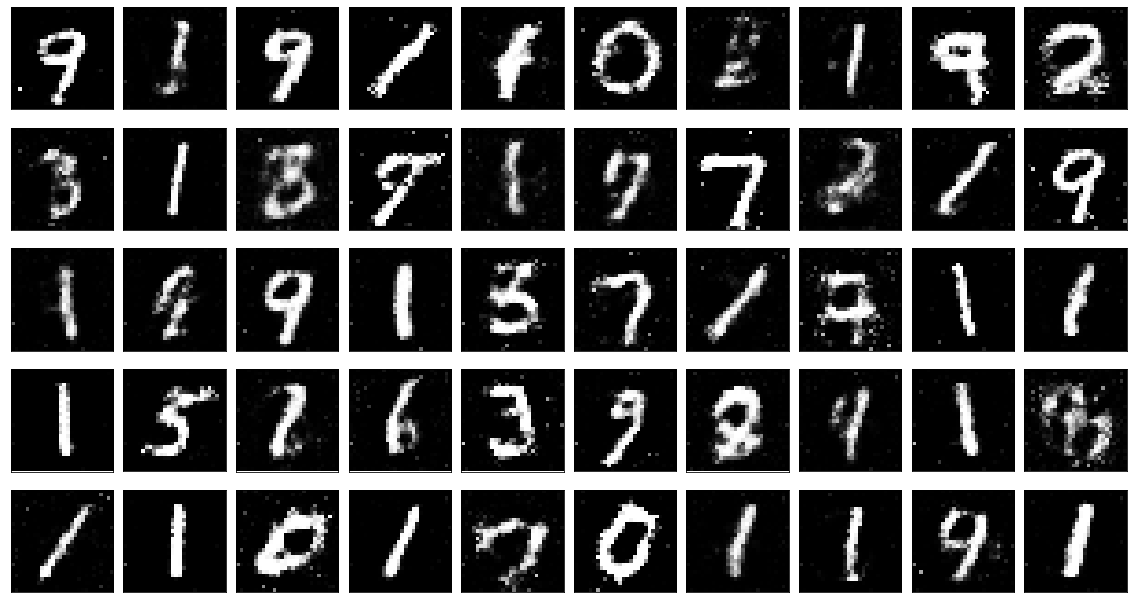

In [11]:
# fake_image作成
generator.eval
noise = torch.randn(50, n_channel, device=device)
y = generator(noise)

# fake_image可視化
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.1, hspace=-0.8)
for i in range(50):
    ax = fig.add_subplot(5, 10, i+1, xticks=[], yticks=[])
    ax.imshow(y[i,].view(28,28).cpu().detach(), "gray")